In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [323]:
vac = pd.read_csv('covid_de_vaccines.csv')

In [324]:
import warnings

# remove warnings
warnings.filterwarnings('ignore')

In [325]:
print(vac.shape)
vac.head()

(115, 9)


,date,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul
0,2020-12-27,24427,24416,11,24427,0,0,24416,11
1,2020-12-28,18383,18383,0,42810,0,0,42799,11
2,2020-12-29,48989,48400,589,91799,0,0,91199,600
3,2020-12-30,62200,62195,5,153999,0,0,153394,605
4,2020-12-31,49971,49831,140,203970,0,0,203225,745


In [326]:
print(vac.describe())

               doses    doses_first   doses_second  pfizer_cumul  \
count     115.000000     115.000000     115.000000  1.150000e+02   
mean   199439.930435  150337.426087   49102.504348  5.853637e+06   
std    156268.527620  138307.992983   29117.946742  4.603208e+06   
min     18383.000000   18383.000000       0.000000  2.442700e+04   
25%     91339.500000   60425.500000   32115.500000  1.911936e+06   
50%    152991.000000   99923.000000   53871.000000  4.943719e+06   
75%    253986.500000  195956.500000   69650.000000  8.841320e+06   
max    770046.000000  687435.000000  102783.000000  1.690507e+07   

       moderna_cumul  astrazeneca_cumul  persons_first_cumul  \
count   1.150000e+02       1.150000e+02         1.150000e+02   
mean    3.123880e+05       1.174321e+06         5.224872e+06   
std     3.617422e+05       1.490719e+06         4.626577e+06   
min     0.000000e+00       0.000000e+00         2.441600e+04   
25%     3.049600e+04       9.800000e+01         1.659138e+06   
50%

In [327]:
vac['date'] = pd.to_datetime(vac['date'], format = '%Y-%m-%d')

In [328]:
vac['cum_sum_doses'] = vac['doses'].cumsum()

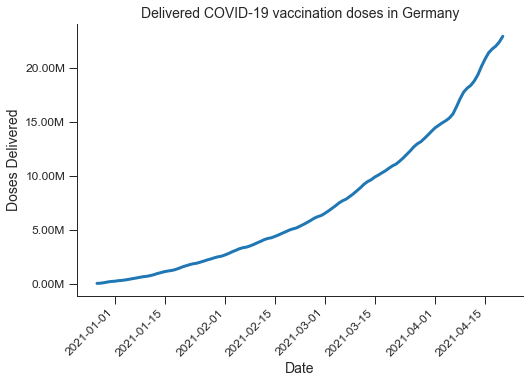

In [329]:
plt.figure(figsize=(8,5))
sns.set_style('ticks')
sns.set_context("poster")
ax = sns.lineplot(x=vac['date'], y=vac['cum_sum_doses'], ci=None)
#ax = sns.lineplot(data=covid_hd_deaths, x='date', y='deaths', ci=None)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=12)
ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels)
plt.setp(ax.spines.values(),linewidth=1)
ax.xaxis.set_tick_params(width=1, length=8)
ax.yaxis.set_tick_params(width=1, length=8)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Doses Delivered', fontsize=14)
plt.title('Delivered COVID-19 vaccination doses in Germany', fontsize=14)
sns.despine()
plt.show()

In [330]:
vaccine = vac.iloc[:,4:7]
vaccine['moderna_cumul'] = vaccine['moderna_cumul'].replace({0:np.nan})
vaccine['astrazeneca_cumul'] = vaccine['astrazeneca_cumul'].replace({0:np.nan})
vaccine

,pfizer_cumul,moderna_cumul,astrazeneca_cumul
0,24427,NaN,NaN
1,42810,NaN,NaN
2,91799,NaN,NaN
3,153999,NaN,NaN
4,203970,NaN,NaN
...,...,...,...
110,15872777,1145659.0,4379878.0
111,16092650,1165531.0,4495361.0
112,16261274,1178493.0,4575251.0
113,16541372,1207842.0,4651180.0


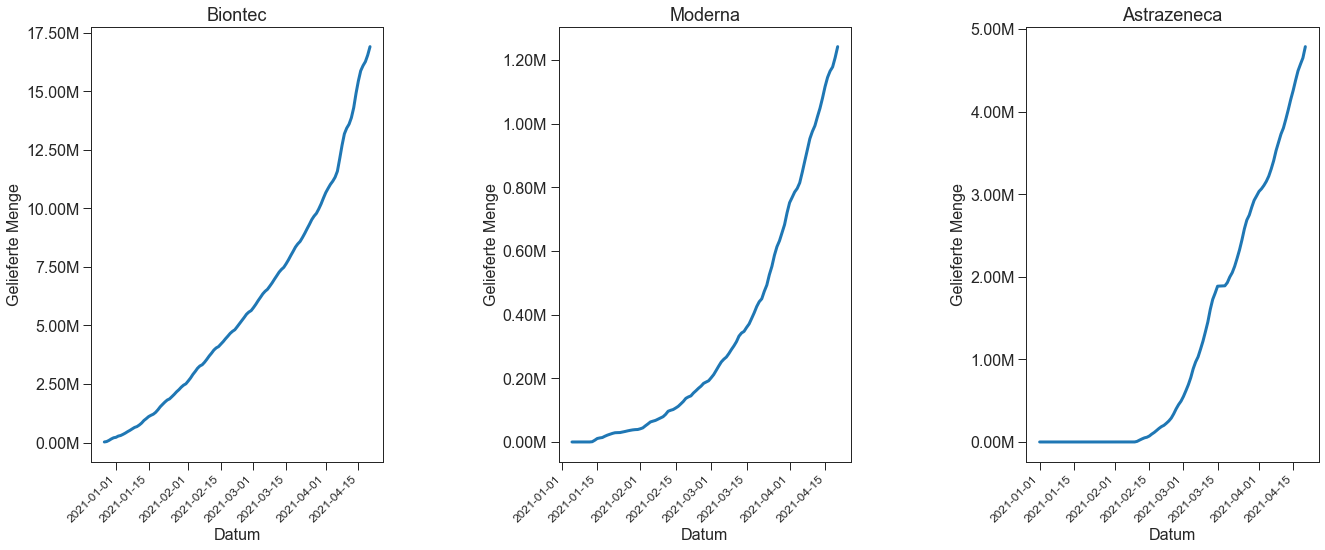

In [331]:

vaccine_label = ['Biontec', 'Moderna', 'Astrazeneca']

fig = plt.figure(figsize=(22,8))

def vac_line(frame):
    for i in range(1, len(vaccine_label)+1):
        ax=fig.add_subplot(1, 3, i)
        plt.plot(vac['date'], frame.iloc[:, i-1:i])
        plt.xticks(rotation=45, horizontalalignment='right', fontsize=12)
        ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax.get_yticks()/1000000]
        ax.set_yticklabels(ylabels)
        plt.setp(ax.spines.values(),linewidth=1)
        ax.xaxis.set_tick_params(width=1, length=8)
        ax.yaxis.set_tick_params(width=1, length=8)
        plt.yticks(fontsize=16)
        plt.title(''+str(vaccine_label[i-1]), fontsize=18)
        plt.xlabel('Datum', fontsize=16)
        plt.ylabel('Gelieferte Menge', fontsize=16)
    plt.subplots_adjust(wspace=0.6)
    
    return plt.show()

vac_line(vaccine)


In [332]:
num_shots = vac.iloc[:, 7:9]
num_shots

,persons_first_cumul,persons_full_cumul
0,24416,11
1,42799,11
2,91199,600
3,153394,605
4,203225,745
...,...,...
110,15960513,5437801
111,16261437,5492105
112,16484590,5530428
113,16811484,5588910


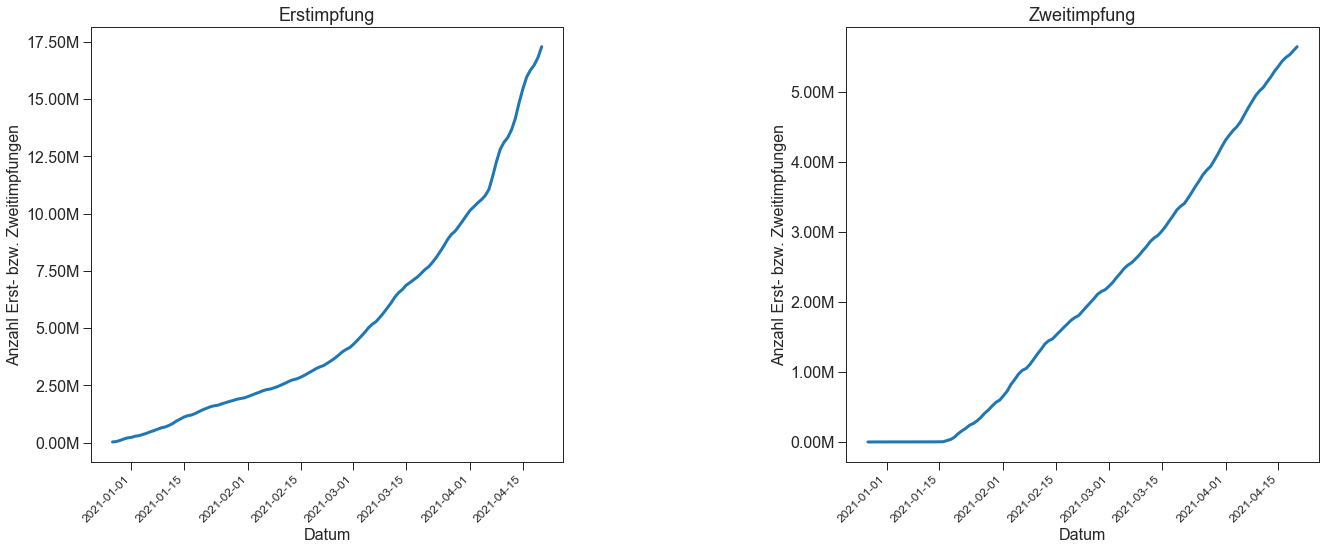

In [333]:
vaccine_shots = ['Erstimpfung', 'Zweitimpfung']

fig = plt.figure(figsize=(22,8))

def vac_line(frame):
    for i in range(1, len(vaccine_shots)+1):
        ax=fig.add_subplot(1,2, i)
        plt.plot(vac['date'], frame.iloc[:, i-1:i])
        plt.xticks(rotation=45, horizontalalignment='right', fontsize=12)
        ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax.get_yticks()/1000000]
        ax.set_yticklabels(ylabels)
        plt.setp(ax.spines.values(),linewidth=1)
        ax.xaxis.set_tick_params(width=1, length=8)
        ax.yaxis.set_tick_params(width=1, length=8)
        plt.yticks(fontsize=16)
        plt.title(''+str(vaccine_shots[i-1]), fontsize=18)
        plt.xlabel('Datum', fontsize=16)
        plt.ylabel('Anzahl Erst- bzw. Zweitimpfungen', fontsize=16)
    plt.subplots_adjust(wspace=0.6)
    
    return plt.show()

vac_line(num_shots)

In [334]:
covid = pd.read_csv('covid_de.csv')

In [335]:
print(covid.shape)
covid.head()

(740545, 8)


,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1


In [336]:
print(covid.describe())

               cases         deaths      recovered
count  740545.000000  740545.000000  740545.000000
mean        4.304626       0.108879       3.812957
std         6.332219       0.483355       5.982108
min         0.000000       0.000000      -1.000000
25%         1.000000       0.000000       1.000000
50%         2.000000       0.000000       2.000000
75%         5.000000       0.000000       4.000000
max       207.000000      20.000000     207.000000


In [337]:
covid['date'] = pd.to_datetime(covid['date'], format = '%Y-%m-%d')

In [338]:
covid_germany = covid.groupby('date')['cases'].sum().reset_index()
covid_germany.head()

,date,cases
0,2020-01-07,1
1,2020-01-19,1
2,2020-01-23,1
3,2020-01-25,1
4,2020-01-28,2


In [339]:
covid_germany['cases_7d_movavg'] = covid_germany['cases'].rolling(7).mean().shift(-3)

In [340]:
covid_germany.head()

,date,cases,cases_7d_movavg
0,2020-01-07,1,NaN
1,2020-01-19,1,NaN
2,2020-01-23,1,NaN
3,2020-01-25,1,1.714286
4,2020-01-28,2,1.714286


In [341]:
vac_covid = covid_germany.merge(vac, on='date', how='left')
vac_covid

,date,cases,cases_7d_movavg,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul,cum_sum_doses
0,2020-01-07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,1,1.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,2,1.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
434,2021-04-16,22925,20087.857143,584797.0,512067.0,72730.0,15872777.0,1145659.0,4379878.0,15960513.0,5437801.0,21398314.0
435,2021-04-17,17458,18990.857143,355228.0,300924.0,54304.0,16092650.0,1165531.0,4495361.0,16261437.0,5492105.0,21753542.0
436,2021-04-18,8656,NaN,261476.0,223153.0,38323.0,16261274.0,1178493.0,4575251.0,16484590.0,5530428.0,22015018.0
437,2021-04-19,11132,NaN,385376.0,326894.0,58482.0,16541372.0,1207842.0,4651180.0,16811484.0,5588910.0,22400394.0


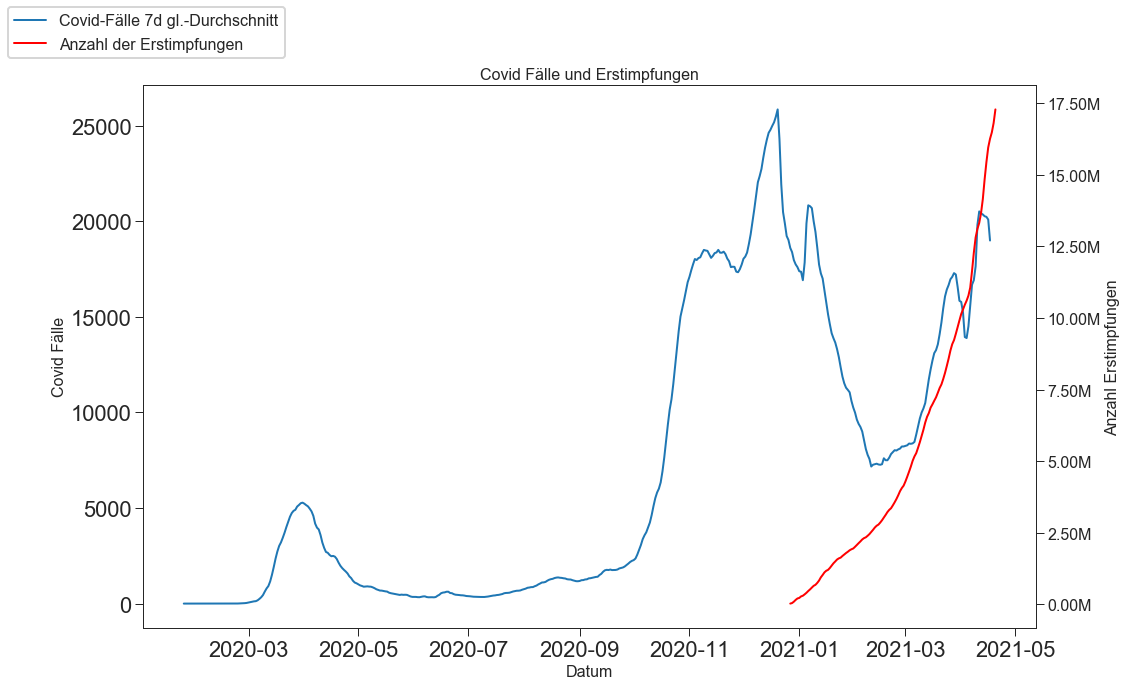

In [342]:
fig_dims = (16,10)
fig, ax1 = plt.subplots(figsize=fig_dims)
sns.set_style('ticks')
sns.set_context("poster")
ax2 = ax1.twinx()
sns.lineplot(x=vac_covid['date'], y=vac_covid['cases_7d_movavg'], ax=ax1, 
             ci=None, linewidth = 2)#, label = '7d gl. Durchschnitt')
sns.lineplot(x=vac_covid['date'], y=vac_covid['persons_first_cumul'], ax=ax2, 
             ci=None, color = 'r', linewidth = 2)#, label = 'Anzahl der Erstimpfungen')

plt.setp(ax1.spines.values(),linewidth=1)
ax1.xaxis.set_tick_params(width=1, length=8)
ax1.yaxis.set_tick_params(width=1, length=8)
plt.setp(ax2.spines.values(),linewidth=1)
ax2.xaxis.set_tick_params(width=1, length=8)
ax2.yaxis.set_tick_params(width=1, length=8)

ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax2.get_yticks()/1000000]
ax2.set_yticklabels(ylabels)

ax1.set_xlabel('Datum', fontsize=16)
ax1.set_ylabel('Covid Fälle', fontsize=16)
ax2.set_ylabel('Anzahl Erstimpfungen', fontsize=16)

ax1 = plt.yticks(fontsize=16)
ax2 = plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

ax1 = plt.xticks(rotation=45, horizontalalignment='right', fontsize=16)

plt.title('Covid Fälle und Erstimpfungen', fontsize=16)
fig.legend(labels=['Covid-Fälle 7d gl.-Durchschnitt', 'Anzahl der Erstimpfungen'], loc='upper left', fontsize=16)

plt.show()

In [343]:
covid_age = covid[['cases']].groupby(covid['date'][covid['age_group'] == '80-99']).sum().reset_index()
covid_age

#vein_pack_lifespans = lifespans['lifespan'][lifespans['pack'] == 'vein']

,date,cases
0,2020-01-23,1
1,2020-02-27,1
2,2020-03-02,1
3,2020-03-04,4
4,2020-03-05,2
...,...,...
411,2021-04-16,694
412,2021-04-17,505
413,2021-04-18,288
414,2021-04-19,442


In [344]:
covid_age2 = covid[['cases']].groupby(covid['date'][covid['age_group'] == '60-79']).sum().reset_index()
covid_age2


,date,cases
0,2020-01-07,1
1,2020-02-12,1
2,2020-02-18,1
3,2020-02-20,1
4,2020-02-27,3
...,...,...
418,2021-04-16,2959
419,2021-04-17,2290
420,2021-04-18,1141
421,2021-04-19,1522


In [345]:
covid['age_group'].unique()

array(['00-04', '05-14', '15-34', '35-59', '60-79', '80-99', nan],
      dtype=object)

In [346]:
covid_age_tot = covid_age.merge(covid_age2, on='date', how='left')
covid_age_tot.rename(columns={'cases_x':'80-99', 'cases_y' : '60-79'}, inplace = True)
covid_age_tot['age_60-99'] = covid_age_tot['80-99'] + covid_age_tot['60-79']
covid_age_tot

,date,80-99,60-79,age_60-99
0,2020-01-23,1,NaN,NaN
1,2020-02-27,1,3.0,4.0
2,2020-03-02,1,8.0,9.0
3,2020-03-04,4,13.0,17.0
4,2020-03-05,2,16.0,18.0
...,...,...,...,...
411,2021-04-16,694,2959.0,3653.0
412,2021-04-17,505,2290.0,2795.0
413,2021-04-18,288,1141.0,1429.0
414,2021-04-19,442,1522.0,1964.0


In [347]:
age_vac = covid_age_tot.merge(vac_covid, on='date', how='left')
age_vac

,date,80-99,60-79,age_60-99,cases,cases_7d_movavg,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul,cum_sum_doses
0,2020-01-23,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,1,3.0,4.0,24,20.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-02,1,8.0,9.0,40,81.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,4,13.0,17.0,156,118.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,2,16.0,18.0,186,128.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2021-04-16,694,2959.0,3653.0,22925,20087.857143,584797.0,512067.0,72730.0,15872777.0,1145659.0,4379878.0,15960513.0,5437801.0,21398314.0
412,2021-04-17,505,2290.0,2795.0,17458,18990.857143,355228.0,300924.0,54304.0,16092650.0,1165531.0,4495361.0,16261437.0,5492105.0,21753542.0
413,2021-04-18,288,1141.0,1429.0,8656,NaN,261476.0,223153.0,38323.0,16261274.0,1178493.0,4575251.0,16484590.0,5530428.0,22015018.0
414,2021-04-19,442,1522.0,1964.0,11132,NaN,385376.0,326894.0,58482.0,16541372.0,1207842.0,4651180.0,16811484.0,5588910.0,22400394.0


In [348]:
age_vac['cases_7d_movavg_age_60-99'] = age_vac['age_60-99'].rolling(7).mean().shift(-3)
age_vac

,date,80-99,60-79,age_60-99,cases,cases_7d_movavg,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul,cum_sum_doses,cases_7d_movavg_age_60-99
0,2020-01-23,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,1,3.0,4.0,24,20.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-02,1,8.0,9.0,40,81.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,4,13.0,17.0,156,118.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,2,16.0,18.0,186,128.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,2021-04-16,694,2959.0,3653.0,22925,20087.857143,584797.0,512067.0,72730.0,15872777.0,1145659.0,4379878.0,15960513.0,5437801.0,21398314.0,3263.857143
412,2021-04-17,505,2290.0,2795.0,17458,18990.857143,355228.0,300924.0,54304.0,16092650.0,1165531.0,4495361.0,16261437.0,5492105.0,21753542.0,3039.857143
413,2021-04-18,288,1141.0,1429.0,8656,NaN,261476.0,223153.0,38323.0,16261274.0,1178493.0,4575251.0,16484590.0,5530428.0,22015018.0,NaN
414,2021-04-19,442,1522.0,1964.0,11132,NaN,385376.0,326894.0,58482.0,16541372.0,1207842.0,4651180.0,16811484.0,5588910.0,22400394.0,NaN


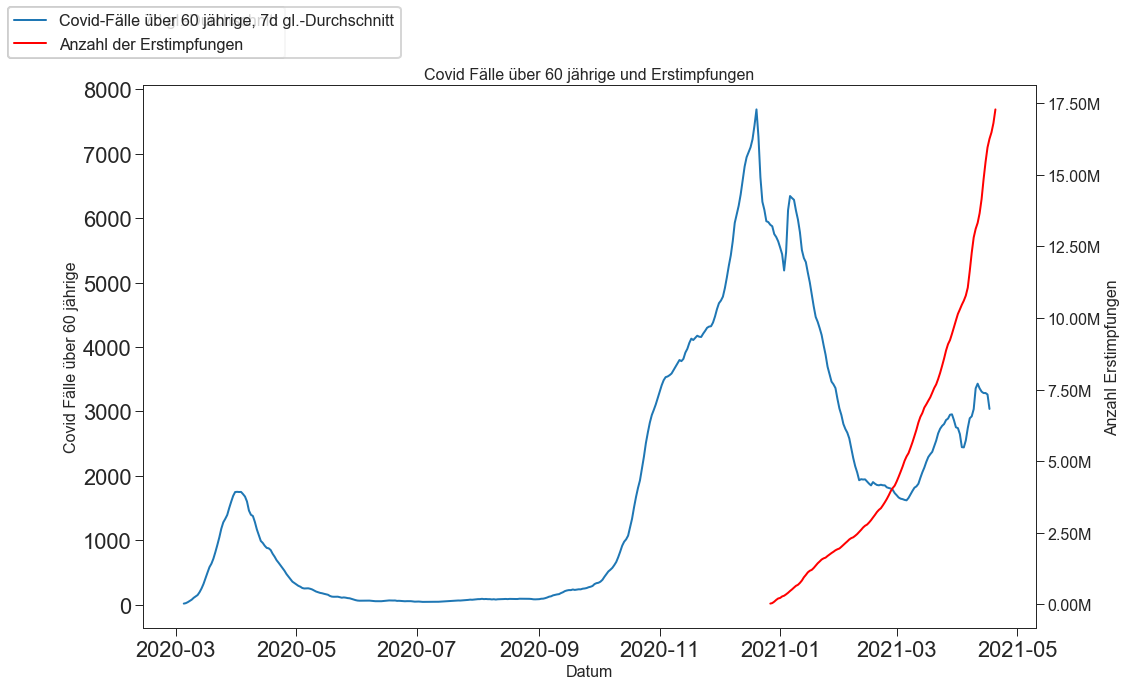

In [349]:
fig_dims = (16,10)
fig, ax1 = plt.subplots(figsize=fig_dims)
sns.set_style('ticks')
sns.set_context("poster")
ax2 = ax1.twinx()
sns.lineplot(x=age_vac['date'], y=age_vac['cases_7d_movavg_age_60-99'], ax=ax1, ci=None, linewidth = 2)
sns.lineplot(x=age_vac['date'], y=age_vac['persons_first_cumul'], ax=ax2, ci=None, color = 'r', linewidth = 2)

plt.setp(ax1.spines.values(),linewidth=1)
ax1.xaxis.set_tick_params(width=1, length=8)
ax1.yaxis.set_tick_params(width=1, length=8)
plt.setp(ax2.spines.values(),linewidth=1)
ax2.xaxis.set_tick_params(width=1, length=8)
ax2.yaxis.set_tick_params(width=1, length=8)

ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax2.get_yticks()/1000000]
ax2.set_yticklabels(ylabels)

ax1.set_xlabel('Datum', fontsize=16)
ax1.set_ylabel('Covid Fälle über 60 jährige', fontsize=16)
ax2.set_ylabel('Anzahl Erstimpfungen', fontsize=16)

ax1 = plt.yticks(fontsize=16)
ax2 = plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

ax1 = plt.xticks(rotation=45, horizontalalignment='right', fontsize=16)

plt.title('Covid Fälle über 60 jährige und Erstimpfungen', fontsize=16)
fig.legend(labels=['Covid-Fälle 7d gl.-Durchschnitt', 'Anzahl der Erstimpfungen'], loc='upper left', fontsize=16)
fig.legend(labels=['Covid-Fälle über 60 jährige, 7d gl.-Durchschnitt', 'Anzahl der Erstimpfungen'], loc='upper left', fontsize=16)
plt.show()

In [350]:
age_vac['cases_7d_movavg_age_80-99'] = age_vac['80-99'].rolling(7).mean().shift(-3)

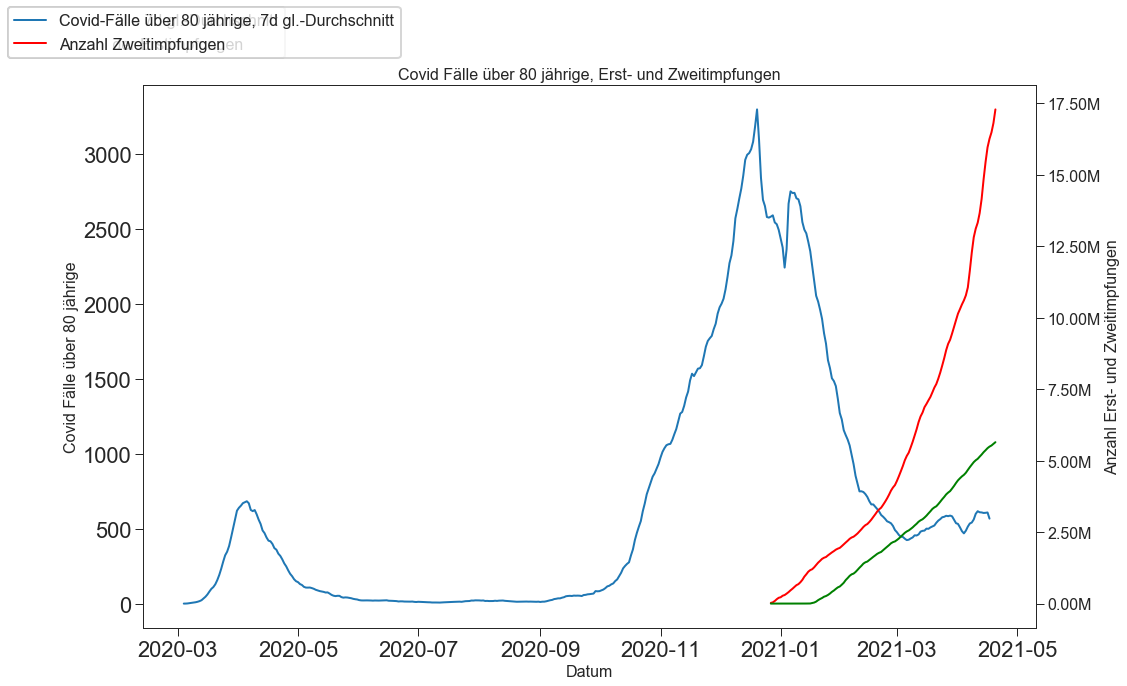

In [351]:
fig_dims = (16,10)
fig, ax1 = plt.subplots(figsize=fig_dims)
sns.set_style('ticks')
sns.set_context("poster")
ax2 = ax1.twinx()
sns.lineplot(x=age_vac['date'], y=age_vac['cases_7d_movavg_age_80-99'], ax=ax1, ci=None, linewidth = 2)
sns.lineplot(x=age_vac['date'], y=age_vac['persons_first_cumul'], ax=ax2, ci=None, color = 'r', linewidth = 2)
sns.lineplot(x=age_vac['date'], y=age_vac['persons_full_cumul'], ax=ax2, ci=None, color = 'g', linewidth = 2)

plt.setp(ax1.spines.values(),linewidth=1)
ax1.xaxis.set_tick_params(width=1, length=8)
ax1.yaxis.set_tick_params(width=1, length=8)
plt.setp(ax2.spines.values(),linewidth=1)
ax2.xaxis.set_tick_params(width=1, length=8)
ax2.yaxis.set_tick_params(width=1, length=8)

ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax2.get_yticks()/1000000]
ax2.set_yticklabels(ylabels)

ax1.set_xlabel('Datum', fontsize=16)
ax1.set_ylabel('Covid Fälle über 80 jährige', fontsize=16)
ax2.set_ylabel('Anzahl Erst- und Zweitimpfungen', fontsize=16)

ax1 = plt.yticks(fontsize=16)
ax2 = plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

ax1 = plt.xticks(rotation=45, horizontalalignment='right', fontsize=16)

plt.title('Covid Fälle über 80 jährige, Erst- und Zweitimpfungen', fontsize=16)
fig.legend(labels=['Covid-Fälle 7d gl.-Durchschnitt', 'Anzahl der Erstimpfungen'], loc='upper left', fontsize=16)
fig.legend(labels=['Covid-Fälle über 80 jährige, 7d gl.-Durchschnitt', 'Anzahl Zweitimpfungen'], loc='upper left', fontsize=16)
plt.show()

In [352]:
age_vac['cases_7d_movavg_age_60-79'] = age_vac['60-79'].rolling(7).mean().shift(-3)

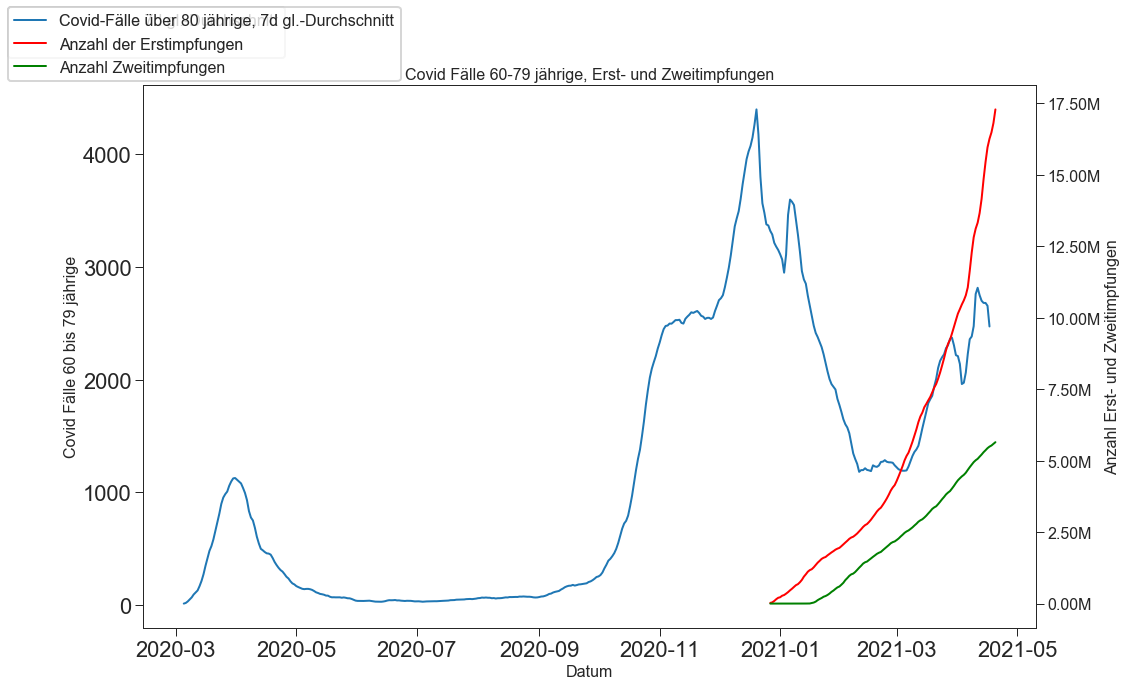

In [353]:
fig_dims = (16,10)
fig, ax1 = plt.subplots(figsize=fig_dims)
sns.set_style('ticks')
sns.set_context("poster")
ax2 = ax1.twinx()
sns.lineplot(x=age_vac['date'], y=age_vac['cases_7d_movavg_age_60-79'], ax=ax1, ci=None, linewidth = 2)
sns.lineplot(x=age_vac['date'], y=age_vac['persons_first_cumul'], ax=ax2, ci=None, color = 'r', linewidth = 2)
sns.lineplot(x=age_vac['date'], y=age_vac['persons_full_cumul'], ax=ax2, ci=None, color = 'g', linewidth = 2)

plt.setp(ax1.spines.values(),linewidth=1)
ax1.xaxis.set_tick_params(width=1, length=8)
ax1.yaxis.set_tick_params(width=1, length=8)
plt.setp(ax2.spines.values(),linewidth=1)
ax2.xaxis.set_tick_params(width=1, length=8)
ax2.yaxis.set_tick_params(width=1, length=8)

ylabels = ['{:,.2f}'.format(x)+ 'M' for x in ax2.get_yticks()/1000000]
ax2.set_yticklabels(ylabels)

ax1.set_xlabel('Datum', fontsize=16)
ax1.set_ylabel('Covid Fälle 60 bis 79 jährige', fontsize=16)
ax2.set_ylabel('Anzahl Erst- und Zweitimpfungen', fontsize=16)

ax1 = plt.yticks(fontsize=16)
ax2 = plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

ax1 = plt.xticks(rotation=45, horizontalalignment='right', fontsize=16)

plt.title('Covid Fälle 60-79 jährige, Erst- und Zweitimpfungen', fontsize=16)
fig.legend(labels=['Covid-Fälle 7d gl.-Durchschnitt', 'Anzahl der Erstimpfungen'], loc='upper left', fontsize=16)
fig.legend(labels=['Covid-Fälle über 80 jährige, 7d gl.-Durchschnitt', 'Anzahl der Erstimpfungen', 'Anzahl Zweitimpfungen'], loc='upper left', fontsize=16)
plt.show()

In [354]:
#forecasting

In [355]:
germany_over_60 = age_vac[['date', 'age_60-99']].dropna()
germany_over_60.head()

,date,age_60-99
1,2020-02-27,4.0
2,2020-03-02,9.0
3,2020-03-04,17.0
4,2020-03-05,18.0
5,2020-03-06,39.0


In [356]:
germany_over_60['age_60-99_7d_mov_avg'] = germany_over_60['age_60-99'].rolling(7).mean().shift(-3)
germany_over_60.head()

,date,age_60-99,age_60-99_7d_mov_avg
1,2020-02-27,4.0,NaN
2,2020-03-02,9.0,NaN
3,2020-03-04,17.0,NaN
4,2020-03-05,18.0,18.285714
5,2020-03-06,39.0,24.857143


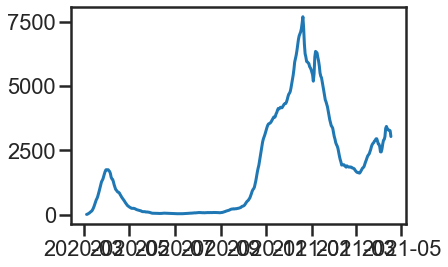

In [357]:
plt.plot(age_vac['date'], age_vac['cases_7d_movavg_age_60-99'])
plt.show()

In [358]:
german_cases_vac = np.array(germany_over_60['age_60-99_7d_mov_avg'].dropna())
german_cases_vac.shape

(409,)

In [359]:
days_since_3_05 = np.array([i for i in range(len(german_cases_vac))]).reshape(-1, 1)
days_since_3_05.shape

(409, 1)

In [360]:
days_in_future = 30
future_forcast = np.array([i for i in range(len(germany_over_60.dropna())+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-30]
future_forcast.shape
#adjusted_dates.shape

(439, 1)

In [361]:
start = '3/05/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

len(future_forcast_dates)

439

In [362]:
#excluding first 50 entries as covid tests were not reliable in this initial phase of the pandamic.

x_train_cases, x_test_cases, y_train_cases, y_test_cases = train_test_split(days_since_3_05[50:], german_cases_vac[50:], test_size=0.20, shuffle=False)

In [363]:
# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

# svm = SVR(kernel='poly', degree=3)
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [364]:
svm_cases = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=0.01,degree=3, C=0.01)
svm_cases.fit(x_train_cases, y_train_cases)

#predict cases (y-value) according to future dates (x-values)
svm_pred = svm_cases.predict(future_forcast)

Mean absolute error: 8030.0622409292655
M squared error: 66353068.12621137


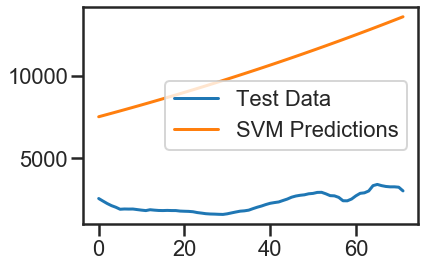

In [365]:
svm_test_pred = svm_cases.predict(x_test_cases)
plt.plot(y_test_cases)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('Mean absolute error:', mean_absolute_error(svm_test_pred, y_test_cases))
print('M squared error:',mean_squared_error(svm_test_pred, y_test_cases))

In [366]:
#run SVM but only with dataset that includes vaccination; the sample size of the data is very low, since vaccination starteed just four months ago

germany_over_60 = age_vac[['date', 'age_60-99']].dropna()
germany_over_60_vaccined = germany_over_60.iloc[300:,:]
germany_over_60_vaccined

,date,age_60-99
301,2020-12-27,3345.0
302,2020-12-28,5119.0
303,2020-12-29,8695.0
304,2020-12-30,9967.0
305,2020-12-31,6104.0
...,...,...
411,2021-04-16,3653.0
412,2021-04-17,2795.0
413,2021-04-18,1429.0
414,2021-04-19,1964.0


In [367]:
germany_over_60_vaccined['age_60-99_7d_mov_avg'] = germany_over_60_vaccined['age_60-99'].rolling(7).mean().shift(-3)
germany_over_60_vaccined

,date,age_60-99,age_60-99_7d_mov_avg
301,2020-12-27,3345.0,NaN
302,2020-12-28,5119.0,NaN
303,2020-12-29,8695.0,NaN
304,2020-12-30,9967.0,5707.857143
305,2020-12-31,6104.0,5641.000000
...,...,...,...
411,2021-04-16,3653.0,3263.857143
412,2021-04-17,2795.0,3039.857143
413,2021-04-18,1429.0,NaN
414,2021-04-19,1964.0,NaN


In [368]:
german_cases_vac = np.array(germany_over_60_vaccined['age_60-99_7d_mov_avg'].dropna())
german_cases_vac.shape

(109,)

In [369]:
days_since_12_30 = np.array([i for i in range(len(germany_over_60_vaccined['age_60-99_7d_mov_avg'].dropna()))]).reshape(-1, 1)
days_since_12_30.shape

(109, 1)

In [370]:
days_in_future = 30
future_forcast_vac = np.array([i for i in range(len(germany_over_60_vaccined.dropna())+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast_vac[:-30]
len(future_forcast)
len(adjusted_dates)

109

In [371]:
start = '12/30/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates_vac = []
for i in range(len(future_forcast)):
    future_forcast_dates_vac.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

len(future_forcast_dates_vac)

439

In [372]:
x_train_cases_vac, x_test_cases_vac, y_train_cases_vac, y_test_cases_vac = train_test_split(days_since_12_30, german_cases_vac, test_size=0.20, shuffle=False)

In [373]:
svm_cases_vaccined = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.01)
svm_cases_vaccined.fit(x_train_cases_vac, y_train_cases_vac)

#predict cases (y-value) according to future dates (x-values)
svm_pred_vac = svm_cases_vaccined.predict(future_forcast_vac)

Mean absolute error: 2751.168531635773
M squared error: 8294290.1074767625


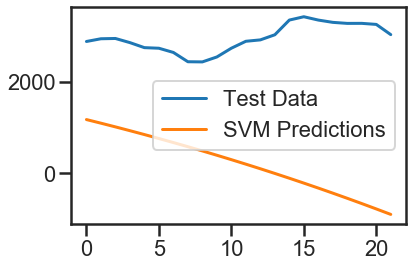

In [374]:
svm_test_pred_vac = svm_cases_vaccined.predict(x_test_cases_vac)
plt.plot(y_test_cases_vac)
plt.plot(svm_test_pred_vac)
plt.legend(['Test Data', 'SVM Predictions'])
print('Mean absolute error:', mean_absolute_error(svm_test_pred_vac, y_test_cases_vac))
print('M squared error:',mean_squared_error(svm_test_pred_vac, y_test_cases_vac))

In [375]:
germany_over_60_vaccined.dropna()

,date,age_60-99,age_60-99_7d_mov_avg
304,2020-12-30,9967.0,5707.857143
305,2020-12-31,6104.0,5641.000000
306,2021-01-01,3212.0,5543.857143
307,2021-01-02,3513.0,5440.142857
308,2021-01-03,2877.0,5188.857143
...,...,...,...
408,2021-04-13,4424.0,3308.857143
409,2021-04-14,4627.0,3286.142857
410,2021-04-15,3955.0,3287.000000
411,2021-04-16,3653.0,3263.857143


In [376]:
germany_vac_cases = age_vac[['date','age_60-99','persons_first_cumul']].iloc[301:,:]
germany_vac_cases

,date,age_60-99,persons_first_cumul
301,2020-12-27,3345.0,24416.0
302,2020-12-28,5119.0,42799.0
303,2020-12-29,8695.0,91199.0
304,2020-12-30,9967.0,153394.0
305,2020-12-31,6104.0,203225.0
...,...,...,...
411,2021-04-16,3653.0,15960513.0
412,2021-04-17,2795.0,16261437.0
413,2021-04-18,1429.0,16484590.0
414,2021-04-19,1964.0,16811484.0


In [377]:
germany_vac_cases['age_60-99_7d_mov_avg'] = germany_vac_cases['age_60-99'].rolling(7).mean().shift(-3)
germany_vac_cases

,date,age_60-99,persons_first_cumul,age_60-99_7d_mov_avg
301,2020-12-27,3345.0,24416.0,NaN
302,2020-12-28,5119.0,42799.0,NaN
303,2020-12-29,8695.0,91199.0,NaN
304,2020-12-30,9967.0,153394.0,5707.857143
305,2020-12-31,6104.0,203225.0,5641.000000
...,...,...,...,...
411,2021-04-16,3653.0,15960513.0,3263.857143
412,2021-04-17,2795.0,16261437.0,3039.857143
413,2021-04-18,1429.0,16484590.0,NaN
414,2021-04-19,1964.0,16811484.0,NaN


In [378]:
german_7d = germany_vac_cases.dropna()
german_7d

,date,age_60-99,persons_first_cumul,age_60-99_7d_mov_avg
304,2020-12-30,9967.0,153394.0,5707.857143
305,2020-12-31,6104.0,203225.0,5641.000000
306,2021-01-01,3212.0,222494.0,5543.857143
307,2021-01-02,3513.0,275076.0,5440.142857
308,2021-01-03,2877.0,299239.0,5188.857143
...,...,...,...,...
408,2021-04-13,4424.0,14156685.0,3308.857143
409,2021-04-14,4627.0,14844120.0,3286.142857
410,2021-04-15,3955.0,15448446.0,3287.000000
411,2021-04-16,3653.0,15960513.0,3263.857143


In [379]:
cases = np.array(german_7d['age_60-99_7d_mov_avg']).reshape(-1,1)
cases.shape

(109, 1)

In [380]:
first_vac = np.array(german_7d['persons_first_cumul']).reshape(-1,1)
first_vac.shape

(109, 1)

In [381]:
line_fitter = LinearRegression()
line_fitter.fit(first_vac, cases)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [382]:
cases_predict = line_fitter.predict(first_vac)

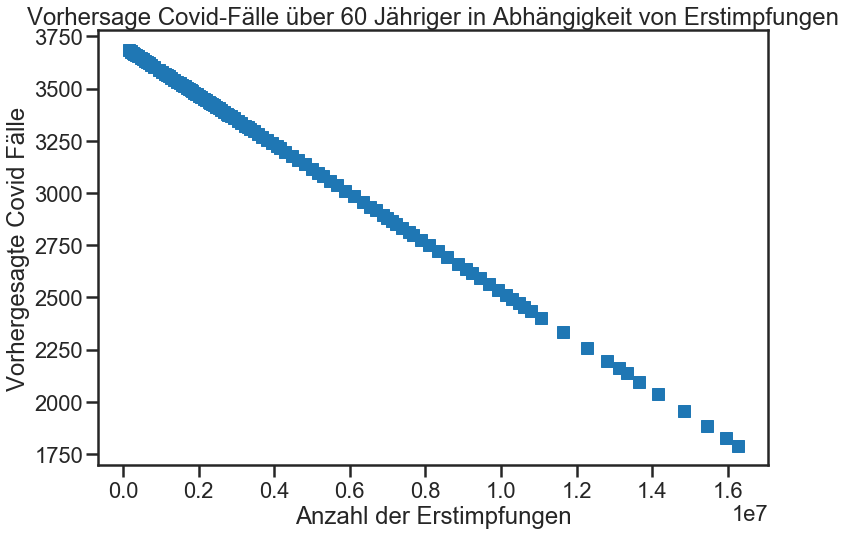

In [383]:
plt.figure(figsize=(12,8))
plt.plot(first_vac, cases_predict, 's')
plt.ylabel('Vorhergesagte Covid Fälle')
plt.xlabel('Anzahl der Erstimpfungen')
plt.title('Vorhersage Covid-Fälle über 60 Jähriger in Abhängigkeit von Erstimpfungen')
plt.show()

In [384]:
line_fitter2 = LinearRegression()
line_fitter2.fit(x_train_cases_vac, y_train_cases_vac)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [385]:
line_fitter2_pred = line_fitter2.predict(future_forcast_vac)

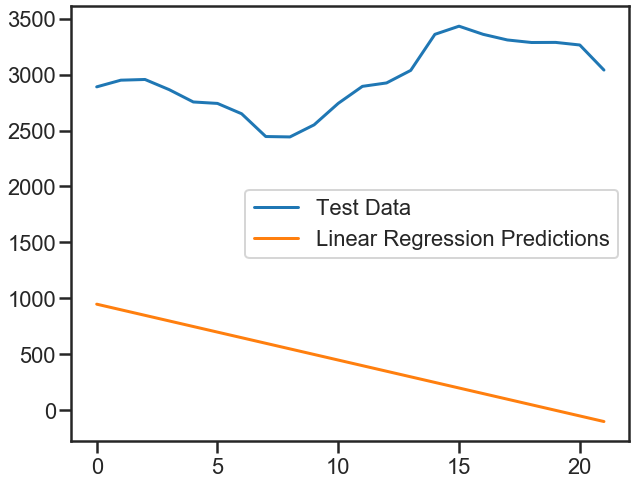

In [386]:
line_fitter2_pred_vac = line_fitter2.predict(x_test_cases_vac)
plt.figure(figsize=(10,8))
plt.plot(y_test_cases_vac)
plt.plot(line_fitter2_pred_vac)
plt.legend(['Test Data', 'Linear Regression Predictions'])

In [387]:
print(line_fitter2.score(x_train_cases_vac, y_train_cases_vac))

0.6838419463912839


In [412]:
poly = PolynomialFeatures(degree=4)
poly_x_train = poly.fit_transform(x_train_cases_vac)
poly_x_test = poly.fit_transform(x_test_cases_vac)
poly_future_forcast = poly.fit_transform(future_forcast_vac)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_x_train = bayesian_poly.fit_transform(x_train_cases_vac)
bayesian_poly_x_test = bayesian_poly.fit_transform(x_test_cases_vac)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast_vac)

In [413]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_x_train, y_train_cases_vac)
test_linear_pred = linear_model.predict(poly_x_test)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_cases_vac))
print('MSE:',mean_squared_error(test_linear_pred, y_test_cases_vac))

MAE: 1038.6315482368175
MSE: 2149435.448977542


In [414]:
print(linear_model.coef_)

[ 5.72150290e+03  6.56454216e+01 -8.73141216e+00  1.55107886e-01
 -7.81485504e-04]


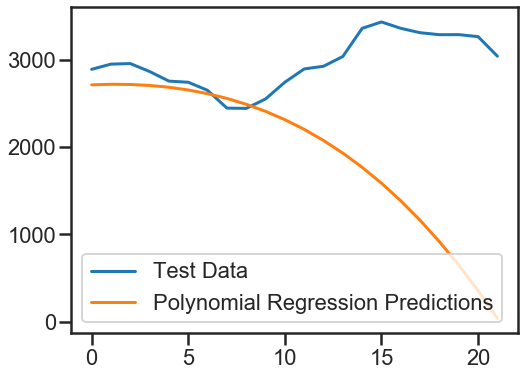

In [415]:
plt.figure(figsize=(8,6))
plt.plot(y_test_cases_vac)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [416]:
#adjusted_dates.shape
#german_cases_vac.shape
svm_pred_vac.shape

(139,)

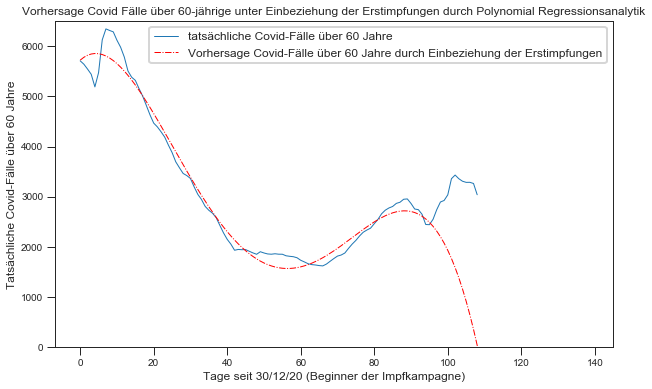

In [417]:
#plot_predictions(adjusted_dates, german_cases_vac, svm_pred_vac, 'SVM Predictions', 'purple')
fig_dims = (10,6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.plot(adjusted_dates, german_cases_vac, linewidth=1)
plt.plot(future_forcast_vac, linear_pred, '-.r', linewidth=1)

plt.setp(ax.spines.values(),linewidth=1)
ax.xaxis.set_tick_params(width=1, length=8)
ax.yaxis.set_tick_params(width=1, length=8)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

ax.set_ylim([0,6500])

plt.xlabel('Tage seit 30/12/20 (Beginner der Impfkampagne)', fontsize = 12)
plt.ylabel('Tatsächliche Covid-Fälle über 60 Jahre', fontsize= 12)
plt.legend(['tatsächliche Covid-Fälle über 60 Jahre', 'Vorhersage Covid-Fälle über 60 Jahre durch Einbeziehung der Erstimpfungen'], fontsize =12)
plt.title('Vorhersage Covid Fälle über 60-jährige unter Einbeziehung der Erstimpfungen durch Polynomial Regressionsanalytik', fontsize=12)
plt.show()

In [418]:
#The prediction on the test data has still a high uncertainty. Therefore, the classifier would need to be optimized when more vaccine data is availabel. 